In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('laptop_price.csv', encoding='latin1')

## Data Understanding

In [3]:
df.head(2)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94


In [4]:
# drop irrelevant features 
df.drop(['laptop_ID', 'Product', 'Weight', 'Inches'], axis=1, inplace=True)

In [5]:
df.shape

(1303, 9)

In [6]:
# check df has null values or not 
df.isnull().sum()

Company             0
TypeName            0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Price_euros         0
dtype: int64

In [7]:
# check df has duplicates or not
df.duplicated().sum()

np.int64(30)

In [8]:
df.dtypes

Company              object
TypeName             object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Price_euros         float64
dtype: object

## Feature Engeenering

In [9]:
# make case-insensitive
for feature in ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys']:
    df[feature] = df[feature].str.lower()

In [10]:
# Extract width and height from resolution and calculate total pixels
df['Total_Pixels'] = df['ScreenResolution'].str.extract(r'(\d+)x').astype(int) * df['ScreenResolution'].str.extract(r'x(\d+)').astype(int)

In [11]:
# laptop is touch-screen or not
def is_tochscreen(laptop):
    if 'touchscreen' in laptop:
        return 1
    else:
        return 0

df['is_tochscreen'] = df['ScreenResolution'].apply(is_tochscreen)

In [12]:
# extract CPU category
def extract_cpu_type(cpu):
    if 'intel core i7' in cpu:
        return 'intel i7'
    elif 'intel core i5' in cpu:
        return 'intel i5'
    elif 'intel core i3' in cpu:
        return 'intel i3'
    elif 'intel pentium' in cpu or 'intel celeron' in cpu:
        return 'intel other'
    elif 'amd ryzen 7' in cpu:
        return 'ryzen 7'
    elif 'amd ryzen 5' in cpu:
        return 'ryzen 5'
    elif 'amd ryzen 3' in cpu:
        return 'ryzen 3'
    elif 'amd' in cpu:
        return 'amd other'
    else:
        return 'other'

df['Cpu_type'] = df['Cpu'].apply(extract_cpu_type)

In [13]:
# formatiing Ram
df['Ram'] = df['Ram'].str.replace('gb','').astype(int)

In [14]:
# converting storage into GB
def convert_storage(val):
    if 'tb' in val:
        return int(float(val.replace('tb', ''))) * 1024
    elif 'gb' in val:
        return int(val.replace('gb', ''))
    return 0

def extract_memory_features(memory_series):
    hdd = []
    ssd = []
    hybrid = []
    flash = []
    
    for entry in memory_series:
        entry = entry.replace(' ', '')
        entry = entry.replace('storage', '')
        hdd_val = ssd_val = hybrid_val = flash_val = 0
        
        for part in entry.split('+'):
            if 'hdd' in part:
                hdd_val += convert_storage(part.replace('hdd', ''))
            elif 'ssd' in part:
                ssd_val += convert_storage(part.replace('ssd', ''))
            elif 'hybrid' in part:
                hybrid_val += convert_storage(part.replace('hybrid', ''))
            elif 'flash' in part:
                flash_val += convert_storage(part.replace('flash', ''))

        hdd.append(hdd_val)
        ssd.append(ssd_val)
        hybrid.append(hybrid_val)
        flash.append(flash_val)
    
    return pd.DataFrame({
        'HDD': hdd,
        'SSD': ssd,
        'Hybrid': hybrid,
        'Flash_Storage': flash
    })

memory_df = extract_memory_features(df['Memory'])
df = pd.concat([df, memory_df], axis=1)

In [15]:
# extracting Gpu brand
df['Gpu_brand'] = df['Gpu'].str.split(' ').str.slice(0,1).str.join(' ')

In [16]:
# extracting operating system type
df['OpSys'] = df['OpSys'].replace('mac os x', 'macos')
df['OpSys'] = df['OpSys'].replace('no os', 'noos')
df['OpSys'] = df['OpSys'].str.split(' ').str.slice(0,1).str.join(' ')

In [17]:
# converting euros into INR
df['Price'] = (df['Price_euros'].astype(int))*90

In [18]:
# drop some unusable columns
df.drop(['ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'Price_euros'], axis=1, inplace=True)

#drop duplicate data
df.drop_duplicates(inplace=True)

## Data Visualization

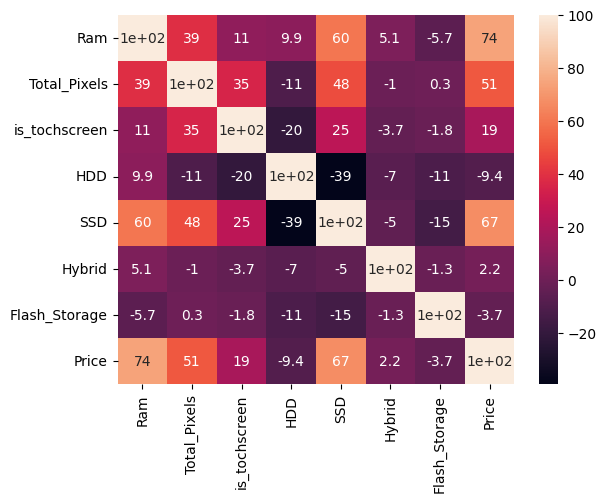

In [19]:
# correleation matrix of df
sns.heatmap(df.drop(['Company', 'TypeName', 'OpSys', 'Cpu_type', 'Gpu_brand'], axis=1).corr()*100, annot=True)
plt.show()

In [20]:
df.describe()

,Ram,Total_Pixels,is_tochscreen,HDD,SSD,Hybrid,Flash_Storage,Price
count,1265.000000,1.265000e+03,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000
mean,8.441107,2.183656e+06,0.148617,418.659289,187.026087,7.686957,4.540711,102291.794466
std,5.104436,1.396903e+06,0.355851,528.242056,188.194789,87.241934,30.606090,63185.429875
min,2.000000,1.049088e+06,0.000000,0.000000,0.000000,0.000000,0.000000,15660.000000
25%,4.000000,2.073600e+06,0.000000,0.000000,0.000000,0.000000,0.000000,55080.000000
50%,8.000000,2.073600e+06,0.000000,0.000000,256.000000,0.000000,0.000000,89010.000000
75%,8.000000,2.073600e+06,0.000000,1024.000000,256.000000,0.000000,0.000000,134820.000000
max,64.000000,8.294400e+06,1.000000,2048.000000,1024.000000,1024.000000,512.000000,548910.000000


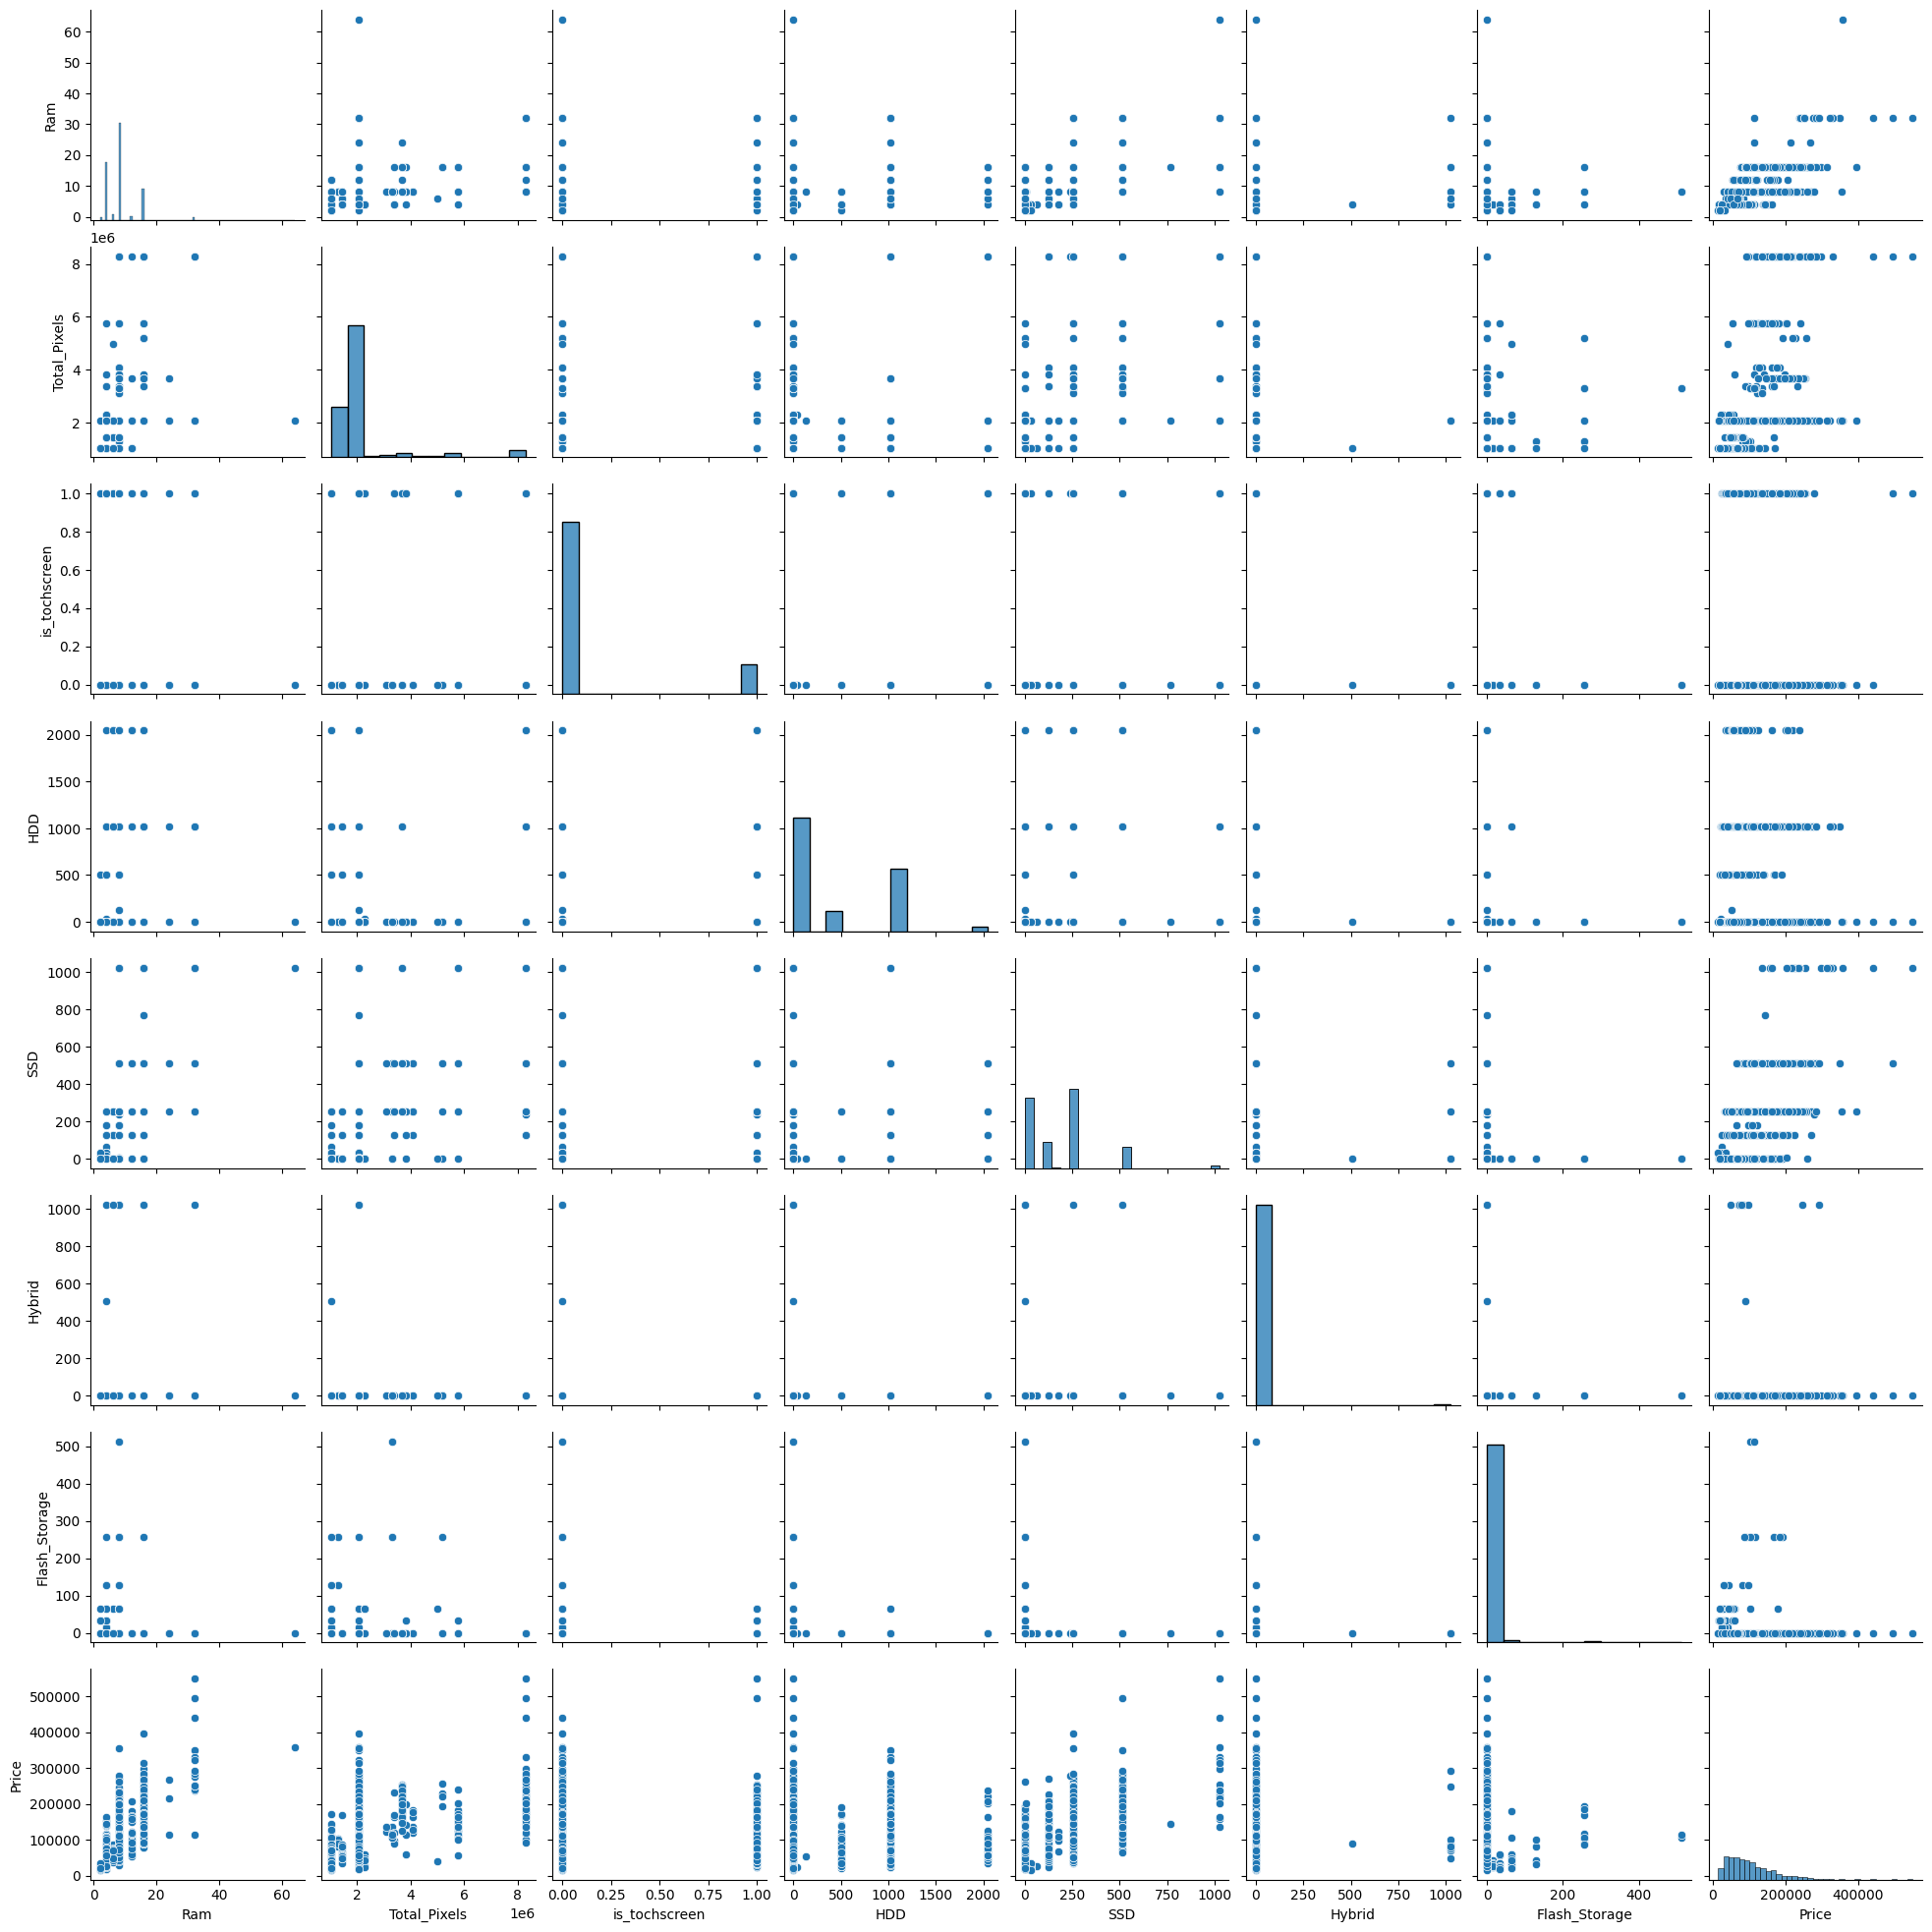

<Figure size 200x200 with 0 Axes>

In [21]:
sns.pairplot(df)
plt.figure(figsize=(2,2))
plt.show()

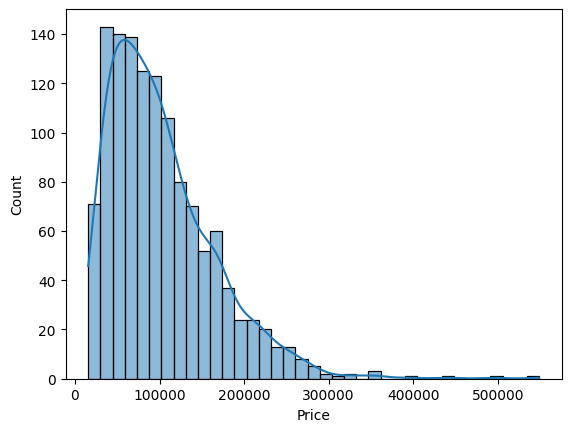

<Figure size 200x200 with 0 Axes>

In [22]:
# distribution of target variable
sns.histplot(df['Price'],kde=True)
plt.figure(figsize=(2,2))
plt.show()

In [23]:
# removing outliers
df = df[df['Price'] < 300000]

## Making Pipeline

In [24]:
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['Company', 'TypeName', 'OpSys', 'Cpu_type', 'Gpu_brand'])
], remainder='passthrough')

In [25]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, subsample=0.8, reg_lambda=2, reg_alpha=0, n_estimators=300, max_depth=5, learning_rate=0.05, gamma=0, colsample_bytree=0.6))
])

In [26]:
# separating dependent and independent variable
x = df.drop('Price', axis=1)
y = df['Price']

 # handling skewness of target variable
y=np.log1p(y)

In [27]:
# spliting into train and train and testing
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [28]:
pipe.fit(xtrain,ytrain)

C:\Users\acre\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company', 'TypeName',
                                                   'OpSys', 'Cpu_type',
                                                   'Gpu_brand'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.6, device...
                              feature_types=None, feature_weights=None, gamma=0,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

## Model Evaluation

In [29]:
# r2 score of a model
pipe.score(xtest, ytest)

0.9069057368602167

In [30]:
ypr = pipe.predict(xtest)
ypr=np.expm1(ypr)
ytest=np.expm1(ytest)

# mean absolute percentage error
mean_absolute_percentage_error(ytest, ypr)

0.15759342947003505

## Model Saving

In [31]:
#import joblib

In [32]:
#joblib.dump(pipe,'pipe.pkl')